In [1]:
from functools import partial

import graspy
from graspy.utils import symmetrize
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import truncnorm, ks_2samp
from scipy.optimize import fmin_slsqp
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from twins import load_dataset
from src import generate_truncnorm_sbms, compute_pr_at_k
%matplotlib inline

/home/ubuntu/env/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
graphs = load_dataset(modality='fmri', parcellation='desikan_res-2x2x2', preprocess=None, ptr=None)[0]

df = pd.read_csv('../../../../twins/data/raw/unrestricted_jaewonc78_1_20_2019_23_7_58.csv')

In [3]:
gender = []
for sub in graphs.keys():
    gender.append(df[df.Subject == int(sub)]['Gender'].values[0])
    
le = LabelEncoder()
labels = le.fit_transform(gender)
# 0 is female, 1 is male

In [4]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([407, 330]))

In [5]:
male_graphs = []
female_graphs = []

for idx, (sub, graph) in enumerate(graphs.items()):
    if labels[idx] == 1:
        male_graphs.append(graph)
    else:
        female_graphs.append(graph)
        
male_graphs = np.array(male_graphs)
female_graphs = np.array(female_graphs)

male_graphs_mean = male_graphs.mean(axis=0)
female_graphs_mean = female_graphs.mean(axis=0)

## Estiamate mean and variance of truncnorm for each edge

In [6]:
def estimate_params(data):
    def func(p, r, xa, xb):
        return truncnorm.nnlf(p, r)

    def constraint(p, r, xa, xb):
        a, b, loc, scale = p
        return np.array([a*scale + loc - xa, b*scale + loc - xb])

    xa, xb = 0, 1

    loc_guess = data.mean()
    scale_guess = data.std()
    
    a_guess = (xa - loc_guess) / scale_guess
    b_guess = (xb - loc_guess) / scale_guess
    p0 = [a_guess, b_guess, loc_guess, scale_guess]

    a, b, mean, std = fmin_slsqp(func, p0, f_eqcons=constraint, args=(data, xa, xb),
                     iprint=False, iter=1000)
    
    return mean, std

In [35]:
verts = male_graphs.shape[-1]

res1 = Parallel(-1, verbose=1)(
    delayed(estimate_params)(male_graphs[:, i, j]) for i in range(verts) for j in range(i+1, verts)
)

res2 = Parallel(-1, verbose=1)(
    delayed(estimate_params)(female_graphs[:, i, j]) for i in range(verts) for j in range(i+1, verts)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 259 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 609 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1059 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1609 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 2415 out of 2415 | elapsed:   14.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 342 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1030 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1709 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 2224 out of 2415 | elapsed:    8.7s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 2415 out of 2415 | elapsed:   12.8s finished


## Compute empirical trustworthiness using the estimated parameters as inputs

In [29]:
def compute_statistic(test, pop1, pop2):
    if test.__name__ == "ttest_ind":
        test_statistics, pvals = ttest_ind(pop1, pop2, axis=0)
        np.nan_to_num(test_statistics, copy=False)
        np.nan_to_num(pvals, copy=False)
    else:  # for other tests, do by edge
        n = pop1.shape[-1]
        test_statistics = np.zeros((n, n))
        pvals = np.zeros((n, n))

        for i in range(n):
            for j in range(i + 1, n):
                x_ij = pop1[:, i, j]
                y_ij = pop2[:, i, j]

                if test.__name__ == "multiscale_graphcorr":
                    tmp, pval, _ = test(x_ij, y_ij, is_twosamp=True, reps=1)
                else:
                    tmp, pval = test(x_ij, y_ij)

                test_statistics[i, j] = tmp
                pvals[i, j] = pval

        test_statistics = symmetrize(test_statistics, method="triu")
        pvals = symmetrize(pvals, method="triu")

    return test_statistics, pvals

def run_experiment(mean_1, var_1, mean_2, var_2, 
                   samp_1=330, samp_2=407,
                   test=ks_2samp, 
                   block_1=5, block_2=15,
                   a=0, b=1, reps=100):

    if np.isnan(mean_1) or np.isnan(mean_2):
        return [mean_1, mean_2, var_1, var_2, 0, 0]
    
       
    pop1, _, _ = generate_truncnorm_sbms(samp_1, block_1, block_2, mean_1, mean_2, var_1, var_2, a=a, b=b)
    _, pop2, true_labels = generate_truncnorm_sbms(samp_2, block_1, block_2, mean_1, mean_2, var_1, var_2, a=a, b=b)

    precisions, recalls = np.zeros((2, reps))
    for i in range(reps):
        test_statistics, pvalues = compute_statistic(test, pop1, pop2)
        precision, recall = compute_pr_at_k(
            k=[10], true_labels=true_labels, pvalues=pvalues
        )
        precisions[i] = precision[0]
        recalls[i] = recall[0]
        
    return [mean_1, mean_2, var_1, var_2, precisions.mean(), recalls.mean()]

In [36]:
res_arr = np.hstack([res1, res2])

args = [
    dict(mean_1=a, var_1=b**2, mean_2=c, var_2=d**2) 
    for (a, b, c, d) in res_arr
]
res = Parallel(n_jobs=-1, verbose=5)(delayed(run_experiment)(**arg) for arg in args)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 690 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed: 21.7min
[Parallel(n_jobs=-1)]: Done 1266 tasks      | elapsed: 28.7min
[Parallel(n_jobs=-1)]: Done 1608 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done 1986 tasks      | elapsed: 44.5min
[Parallel(n_jobs=-1)]: Done 2415 out of 2415 | elapsed: 53.4min finished


In [37]:
df = pd.DataFrame(res, columns=["mean_1", "mean_2", "var_1", "var_2", "precision", "recall"])

In [52]:
df.to_csv("../20200320_hcp.csv", index=False)

## Figure

In [49]:
empirical_trustworthiness = np.zeros((verts, verts))
empirical_trustworthiness[np.triu_indices(verts, k=1)] = df.recall.values
empirical_trustworthiness = symmetrize(empirical_trustworthiness, method='triu')

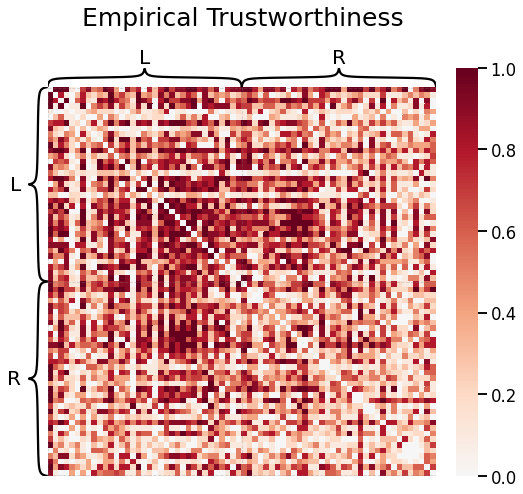

In [50]:
node_labels = ['L'] * 35 + ['R'] * 35

with sns.plotting_context('talk'):
    fig, ax = plt.subplots(
        figsize=(7, 6),
        ncols=2, 
        gridspec_kw={"width_ratios": [1, 0.05]},
        constrained_layout=True
    )

    graspy.plot.heatmap(empirical_trustworthiness, inner_hier_labels=node_labels,
                        vmin=0, vmax=1, ax=ax[0], cbar_ax=ax[-1],
                       hier_label_fontsize=20)

    fig.text(.45, 1.075, "Empirical Trustworthiness", fontsize=25, ha='center')
    #ax[0].set_title("Empirical Trustworthiness")

In [51]:
fig.savefig("./exp2_empirical_trustworthiness.png", dpi=300, bbox_inches='tight')
fig.savefig("./exp2_empirical_trustworthiness.pdf", dpi=300, bbox_inches='tight')